In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import re

In [2]:
#Read CSV files into pandas dataframe
data = pd.read_csv(r".\data.csv")

# Clean Data

In [3]:
#Looking at percent missing in each column will help decide how best to validate, clean, and analyze the data
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by='percent_missing')

,percent_missing
COUNTRY_ISO2,0.000000
SEGMENT_CD,0.000000
EMPL_SIZE_RANGE,0.000000
REVENUE,0.000000
QUANTITY,0.000000
FIRST_NAME,0.000000
twitterFollowers,0.000000
PRODUCT_LOB,0.216946
PRODUCT_BRAND,0.337471
PRODUCT_FAMILY,0.349524


In [4]:
#PRODUCT_LOB contains fewer product categories than the other product columns and also has the least number of missing values
data.PRODUCT_LOB.unique()

array(['Accessories & upgrades', 'Laptops', 'Services', 'Notebook',
       'Desktops', 'Think Peripherals', 'S&P', 'Monitors', 'Desktop',
       'All-in-One', 'Mobile Internet Digital Home', 'Workstation',
       'Visuals', 'Servers', 'Mobile Internet Digi', 'Workstations',
       'LCS ??', nan, 'All-in-Ones', 'Mobile Internet Digital Hardware',
       'LVO Services', 'Enterprise Product Group'], dtype=object)

In [5]:
data.PRODUCT_LOB = data.PRODUCT_LOB.replace({'Accessories & upgrades': 'Accessories & Upgrades'})
data.PRODUCT_LOB = data.PRODUCT_LOB.replace(r'Mobile+.+Dig.+', 'Mobile Internet Digital', regex=True)
data.PRODUCT_LOB = data.PRODUCT_LOB.replace('Workstations', 'Workstation')
data.PRODUCT_LOB = data.PRODUCT_LOB.replace('LCS ??', 'LCS')
data.PRODUCT_LOB = data.PRODUCT_LOB.replace('Desktops', 'Desktop')
data.PRODUCT_LOB = data.PRODUCT_LOB.replace('All-in-Ones', 'All-in-One')

In [6]:
data.PRODUCT_LOB.unique()

array(['Accessories & Upgrades', 'Laptops', 'Services', 'Notebook',
       'Desktop', 'Think Peripherals', 'S&P', 'Monitors', 'All-in-One',
       'Mobile Internet Digital', 'Workstation', 'Visuals', 'Servers',
       'LCS', nan, 'LVO Services', 'Enterprise Product Group'],
      dtype=object)

# Identify customers and assign unique ids
This data set doesn't have unique ids for the customers. To do the segmentation, I need to identify the repeat customers. I can group by the columns with a dropna parameter value of false and use the ngroup method. Once this is done, we can aggregate the revenue and quantity columns grouping by id to return the total revenue and quantity of items across all transactions for each customer. 

In [7]:
cust_ids = data.groupby(
    ['FIRST_NAME', 'TITLE', 'MAIL_ADDRESS2', 'MAIL_REGION', 'MAIL_CITY',
       'MAIL_POSTAL_CD', 'MAIL_CTRY_CD', 'website1', 'age', 'gender',
       'ageRange', 'locationGeneral', 'interest1', 'interest2', 'interest3',
       'interest4', 'interest5', 'kloutScore', 'twitterFollowers',
       'facebookFriends', 'googlePlusId', 'organization', 'title2'], dropna=False).ngroup()
data['id'] = cust_ids
revenue_by_customer = data[['id', 'REVENUE', 'QUANTITY']].groupby('id').sum().sort_values(by='REVENUE', ascending=False)
revenue_by_customer.describe()

,REVENUE,QUANTITY
count,3592.000000,3592.000000
mean,1530.950724,3.058185
std,2809.253272,15.394857
min,2.000000,1.000000
25%,545.000000,1.000000
50%,1049.000000,2.000000
75%,1702.250000,3.000000
max,89057.000000,818.000000


Count the number of transactions per customer

In [9]:
data['transactions'] = 1
num_transactions = data[['id', 'transactions']].groupby('id').count()
num_transactions.describe()

,transactions
count,3592.000000
mean,2.309855
std,2.683226
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,56.000000


In [15]:
np.percentile(revenue_by_customer['REVENUE'], 25)

545.0

In [19]:
np.percentile(revenue_by_customer['QUANTITY'], 50)

2.0

# Segment the data
There are a number of ways we can segment the data. We can segment the data using kmeans as I do in the next section. But, before we do that, I will use percentiles to define thresholds between Low/Medium/High revenue and quantity groups and then use those values to assign an overall value score for each customer.

In [20]:
revenue_by_customer['RevenueValue'] = "Medium"
revenue_by_customer.loc[revenue_by_customer.REVENUE<=np.percentile(revenue_by_customer['REVENUE'], 25),'RevenueValue'] = 'Low'
revenue_by_customer.loc[revenue_by_customer.REVENUE > np.percentile(revenue_by_customer['REVENUE'], 75), 'RevenueValue'] = 'High'

In [21]:
revenue_by_customer['QuantityValue'] = 'Medium'
revenue_by_customer.loc[revenue_by_customer.QUANTITY <= np.percentile(revenue_by_customer['QUANTITY'], 50), 'QuantityValue'] = 'Low'
revenue_by_customer.loc[revenue_by_customer.QUANTITY > np.percentile(revenue_by_customer['QUANTITY'], 99), 'QuantityValue'] = 'High'

In [22]:
revenue_by_customer['OverallValue'] = 'Medium'
revenue_by_customer.loc[(revenue_by_customer.QuantityValue == 'High') & (revenue_by_customer.RevenueValue == 'High'), 'OverallValue'] = 'High'
revenue_by_customer.loc[(revenue_by_customer.QuantityValue == 'Low') & (revenue_by_customer.RevenueValue == 'Low'), 'OverallValue'] = 'Low'

In [23]:
revenue_by_customer = revenue_by_customer.merge(num_transactions, on='id')
revenue_by_customer

,REVENUE,QUANTITY,RevenueValue,QuantityValue,OverallValue,transactions
id,,,,,,
967,89057,288,High,High,High,14
1149,65807,120,High,High,High,3
2486,47844,216,High,High,High,18
274,32043,29,High,High,High,11
525,26824,24,High,High,High,2
...,...,...,...,...,...,...
3025,5,1,Low,Low,Low,1
1846,4,2,Low,Low,Low,2
2110,4,2,Low,Low,Low,2


# Create a new feature: Influencers
This section creates a new feature from twitterFollowers, identifying customers who are influencers on Twitter.

In [42]:
influencers = data[data['twitterFollowers'] >np.percentile(data.twitterFollowers, 99)].sort_values(by='twitterFollowers', ascending=False)
data['Influencer'] = 0
data.loc[data['twitterFollowers'] >np.percentile(data.twitterFollowers, 99), 'Influencer'] = 1

# Transform interest columns
This section transforms the interest columns, giving each interest its own columns, so that we can aggregate and analyze the interests more easily.

In [43]:
interest_cols = ['interest1', 'interest2', 'interest3', 'interest4']
for interest_col in interest_cols:
    data[interest_col].apply(lambda x: str(x).upper())
    data[interest_col] = data[interest_col].str.strip('.')
    data[interest_col] = data[interest_col].str.strip(',')
    data[interest_col] = data[interest_col].str.strip()

In [44]:
interest1 = data[interest_cols[0]]
interests = data[interest_cols[1:]]

for each in interests:
    interest1.append(interests[each])

interests_series = interest1.sort_values().unique()

#create new columns
for interest in interests_series:
    data[interest] = 0
    
for interest in interests_series:
        for interest_col in interest_cols:
            data.loc[data[interest_col]==interest, interest] = 1

In [45]:
merged = pd.merge(
    revenue_by_customer,
    data,
    how="inner",
    on='id',
    suffixes=("_sum", "_ind")
)

In [46]:
cols = list(interests_series)
cols.append('OverallValue')
cols.append('id')
customer_interests = merged[cols].groupby(['id', 'OverallValue']).mean()
customer_interests = customer_interests.reset_index()

cols = list(interests_series)
cols.append('OverallValue')

customer_interests = customer_interests[cols].groupby(['OverallValue']).mean().T
customer_interests.sort_values(by='Medium', ascending=False)

OverallValue,High,Low,Medium
Software,0.333333,0.176678,0.152399
Business,0.121212,0.144876,0.142066
Religion and Spirituality,0.151515,0.107185,0.105535
Finance,0.090909,0.084806,0.081550
Journalism,0.060606,0.098940,0.079336
...,...,...,...
Careers,0.000000,0.001178,0.000000
South Florida,0.000000,0.001178,0.000000
Somerset,0.000000,0.001178,0.000000
Gustavus Adolphus College,0.000000,0.001178,0.000000


# Transform Product_Lob
This section is similar to the last with the ultimate goal of analyzing Product_Lob by different segments of the data

In [47]:
products = merged[['OverallValue','PRODUCT_LOB', 'id']]
col_list = list(products['PRODUCT_LOB'].unique())
col_list.append('OverallValue')
col_list.remove(np.nan)

products = products.join(pd.get_dummies(products['PRODUCT_LOB']))
products_grouped_by_value = products[col_list].groupby(['OverallValue']).mean().T
products_grouped_by_value.sort_values(by='High', ascending=False)

OverallValue,High,Low,Medium
Accessories & Upgrades,0.340357,0.346597,0.233011
Services,0.183144,0.169634,0.160892
Laptops,0.145867,0.057592,0.247138
Notebook,0.141005,0.123560,0.192714
Think Peripherals,0.063209,0.033508,0.045948
S&P,0.055105,0.070157,0.034052
Desktop,0.030794,0.071204,0.048476
Visuals,0.012966,0.003141,0.004015
Monitors,0.008104,0.001047,0.002974
All-in-One,0.006483,0.013613,0.014126


# Use Kmeans to cluster customers based on similar features
This section uses kmeans to cluster the customers based on similar features. We will use revenue, quantity and transactions to identify customer segments. When doing kmeans clustering, it is best to use fewer features to output fewer clusters that are hold a lot of value. If we used more features and split the data into more groups, the output would likely be less engaging to clients. 

In [48]:
features = ['REVENUE','QUANTITY', 'transactions']
features = revenue_by_customer[features]

In [49]:
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(features)
scaled_features

array([[31.16067752, 18.5114733 ,  4.35735636],
       [22.88330457,  7.59721871,  0.2572429 ],
       [16.48818843, 13.83393562,  5.84830671],
       ...,
       [-0.54361895, -0.06874583, -0.11549469],
       [-0.54433098, -0.13371163, -0.48823228],
       [-0.54433098, -0.13371163, -0.48823228]])

In [50]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=0)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=0)

In [51]:
revenue_by_customer["Cluster"] = kmeans.labels_

In [52]:
revenue_by_customer.groupby('Cluster').agg({
    'REVENUE':'mean',
    'QUANTITY':'mean',
    'RevenueValue':pd.Series.mode,
    'QuantityValue':pd.Series.mode,
    'OverallValue':pd.Series.mode,
     'transactions':{'mean', 'count'}}).round(2)

REVENUE QUANTITY RevenueValue QuantityValue OverallValue  \
             mean     mean         mode          mode         mode   
Cluster                                                              
0         1044.55     1.83       Medium           Low       Medium   
1        23686.15    97.95         High          High         High   
2         4649.86     8.73         High        Medium       Medium   

        transactions        
                mean count  
Cluster                     
0               1.70  3213  
1              23.85    20  
2               6.54   359

In [53]:
revenue_by_customer.groupby('Cluster').agg({
    'REVENUE':'mean',
    'QUANTITY':'mean',
    'RevenueValue':pd.Series.mode,
    'QuantityValue':pd.Series.mode,
    'OverallValue':pd.Series.mode,
     'transactions':{'mean', 'count'}}).round(2)

REVENUE QUANTITY RevenueValue QuantityValue OverallValue  \
             mean     mean         mode          mode         mode   
Cluster                                                              
0         1044.55     1.83       Medium           Low       Medium   
1        23686.15    97.95         High          High         High   
2         4649.86     8.73         High        Medium       Medium   

        transactions        
                mean count  
Cluster                     
0               1.70  3213  
1              23.85    20  
2               6.54   359

In [58]:
col_list = list(products['PRODUCT_LOB'].unique())
col_list.remove(np.nan)
products_grouped_by_id = products[col_list + ['id']].groupby('id').sum()
products_revenue = revenue_by_customer.merge(products_grouped_by_id, on='id', suffixes=('', '_y'))

In [59]:
mapper = {1:'Bulk Shoppers', 0: 'Infrequent Purchasers', 2: 'Loyal Customers'}
products_revenue.Cluster = products_revenue.Cluster.replace(mapper)

In [66]:
products_revenue[col_list + ['Cluster']].groupby('Cluster').sum().T.sort_values(by='Loyal Customers', ascending=False)

Cluster,Bulk Shoppers,Infrequent Purchasers,Loyal Customers
Accessories & Upgrades,172.0,1178.0,758.0
Laptops,65.0,1284.0,458.0
Services,95.0,865.0,397.0
Notebook,58.0,1173.0,270.0
Think Peripherals,33.0,199.0,148.0
Desktop,10.0,274.0,129.0
S&P,26.0,217.0,87.0
All-in-One,4.0,78.0,30.0
Visuals,7.0,12.0,19.0
Monitors,3.0,9.0,14.0


C:\Users\rayde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Scaled Value'>

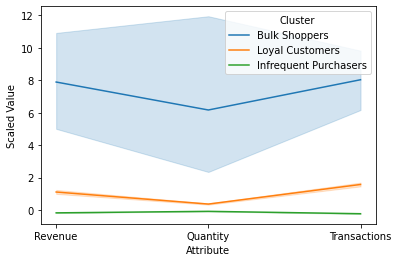

In [67]:
import seaborn as sns
# Create the dataframe
df_normalized = pd.DataFrame(scaled_features, columns=['Revenue','Quantity', 'Transactions'])
df_normalized['ID'] = revenue_by_customer.index
df_normalized['Cluster'] = kmeans.labels_
df_normalized.Cluster = df_normalized.Cluster.replace(mapper)
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Revenue','Quantity', 'Transactions'],
                      var_name='Attribute',
                      value_name='Scaled Value')
df_nor_melt.head()

# Visualize it
sns.lineplot('Attribute', 'Scaled Value', hue='Cluster', data=df_nor_melt)

# Analyzing the keyword dataset

In [138]:
cols = ['Keyword', 'lenovo.com', 'laptopmag.com', 'Search Volume', 'Keyword Difficulty', 'CPC', 'Competition', 'Results']

keywords.Keyword.str.replace('(?i)Lap+.?top+?', 'Laptop', regex=True)
        
keywords_grouped = keywords[cols].groupby('Keyword').sum()

In [ ]:
affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", random_state=None)
affprop.fit(spatial.distance.squareform(sim))

In [ ]:
res = keywords.groupby(affprop.labels_).agg(
        Names=('Name',','.join),
        First_ID=('ID','first'),
        Total_Value=('Value','sum'),
        Group_Size=('Value','count')
        )

In [102]:
keywords['Ranking_Difference'] = abs(keywords['laptopmag.com'] - keywords['data.com'])
keywords['volume_difficulty'] = (keywords['Search Volume']/(keywords['Keyword Difficulty']*keywords['Ranking_Difference']))
keywords['volume_cpc'] = keywords['Search Volume'] / keywords['CPC']

In [106]:
keywords.Keyword.unique()

array(['xbox series x', 'chromebook', 'laptop', ...,
       '8gb ram for lenovo laptop', '8gb ram good for gaming',
       '8gb ram i5 ssd laptop'], dtype=object)

In [134]:
cols = ['Keyword', 'data.com', 'laptopmag.com', 'Search Volume', 'Keyword Difficulty', 'CPC', 'Competition', 'Results']
import re
for x in keywords.Keyword:
    y = re.match('(?i)Lap+.?top+?', x)
    if y is not None:
        x.replace('(?i)Lap+.?top+?', 'Laptop')
keywords_grouped = keywords.groupby('Keyword').

In [135]:
# Volume to CPC Ratio
keywords[(keywords['data.com'].isin(range(2, 10))) & keywords.CPC >0].sort_values(by=['volume_cpc'], ascending=False).head()

,Keyword,lenovo.com,laptopmag.com,Search Volume,Keyword Difficulty,CPC,Competition,Results,lenovo.com (pages),laptopmag.com (pages),Ranking_Difference,volume_difficulty,volume_cpc
11,computer monitor,9,6,246000,93.29,0.47,1.00,4190000000,https://www.lenovo.com/us/en/d/deals/computer-...,https://www.laptopmag.com/articles/best-cheap-...,3,878.979526,523404.255319
199,chromebook vs laptop,4,8,18100,86.16,0.12,0.97,98900000,https://www.lenovo.com/us/en/faqs/laptop-faqs/...,https://www.laptopmag.com/articles/chromebooks...,4,52.518570,150833.333333
124,rift s,9,21,33100,92.68,0.31,0.90,95500000,https://www.lenovo.com/us/en/brands/oculus/,https://www.laptopmag.com/reviews/oculus-rift-s,12,29.761905,106774.193548
145,logitech mx master 3,9,16,27100,86.87,0.38,1.00,7920000,https://www.lenovo.com/us/en/accessories-and-m...,https://www.laptopmag.com/reviews/accessories/...,7,44.565772,71315.789474
379,difference between chromebook and laptop,2,12,9900,83.14,0.14,0.92,74300000,https://www.lenovo.com/us/en/faqs/laptop-faqs/...,https://www.laptopmag.com/articles/chromebooks...,10,11.907626,70714.285714


In [109]:
# By Volume to Difficulty level adjusted for the ranking difference between data and Laptopmag.com
keywords[(keywords['data.com'].isin(range(2, 10)))].sort_values(by=['volume_difficulty'], ascending=False).head()

,Keyword,lenovo.com,laptopmag.com,Search Volume,Keyword Difficulty,CPC,Competition,Results,lenovo.com (pages),laptopmag.com (pages),Ranking_Difference,volume_difficulty,volume_cpc
11,computer monitor,9,6,246000,93.29,0.47,1.0,4190000000,https://www.lenovo.com/us/en/d/deals/computer-...,https://www.laptopmag.com/articles/best-cheap-...,3,878.979526,5.234043e+05
290,used laptops,8,10,14800,85.53,0.78,1.0,1880000000,https://www.lenovo.com/us/en/faqs/laptop-faqs/...,https://www.laptopmag.com/articles/best-refurb...,2,86.519350,1.897436e+04
178,lap tops,9,13,22200,92.97,1.50,1.0,1940000000,https://www.lenovo.com/us/en/laptops/c/LAPTOPS,https://www.laptopmag.com/reviews/best-laptops-1,4,59.696676,1.480000e+04
248,computer monitor deals,4,7,14800,91.30,0.48,1.0,1080000000,https://www.lenovo.com/us/en/d/deals/computer-...,https://www.laptopmag.com/news/best-monitor-deals,3,54.034319,3.083333e+04
30,how to screenshot on chromebook,9,39,135000,85.47,0.00,0.0,0,https://support.lenovo.com/us/en/solutions/ht1...,https://www.laptopmag.com/articles/how-to-take...,30,52.650053,inf
